In [283]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

In [284]:
df = pd.read_csv ('Newfile_RF-04_DISCOVER-AQ', dtype='float', na_values = '-999999')

In [285]:
'''Takes + or - trend value and return a list of different dataframes with ascent and descent profiles'''

def dataframe(trend):
    derivative = df['GPS_ALT'].diff(periods=60) / df['UTC'].diff(periods=60) 
    df['trend'] = derivative.gt(0).map({False: -1, True: 1})
    
    if trend >= 0:
        
        '''Flight observations while the plane is going up == Difference in altitude for subsequnt points is always poistive.
           So, the difference will be negative whenever the plane starts to come down.
           Divide the dataset according to indices when the plane starts coming down'''
        
        idx = df.index[df['trend'] == 1].dropna()
        dataset_profile = df.loc[idx].dropna(subset=['GPS_ALT', 'THETA'])
        reqd_Index = np.where(dataset_profile['GPS_ALT'].diff() < -1.0)
        
    else:
        
        '''Flight observations while the plane is coming down == Difference in altitude for subsequnt points is always negative.
           Divide the dataset according to indices when the plane starts going up and the difference becomes positive'''
        
        idx = df.index[df['trend'] == -1].dropna()
        dataset_profile = df.loc[idx].dropna(subset=['GPS_ALT', 'THETA'])
        reqd_Index = np.where(dataset_profile['GPS_ALT'].diff() > 1.0)
    
    final_index = np.asarray(reqd_Index[0])
    diff = np.diff(final_index)
    empty_array = np.arange(0,len(diff),1)
        
    df_list=[]
    i = 0
    for i in empty_array:
        start = final_index[i]
        end = diff[i]+start
        dfx = dataset_profile.iloc[start:end]
        df_list.append(dfx)
    return df_list

Up_sounding = dataframe(1)
Down_sounding = dataframe(-1)

Temperature Gradient Method(TGRD) Method. 
"The CTBL and CBL are generally capped by a well-defined temperature inversion with a substantial maximum in the lapse rate of potential temperature (Figs. 1 and 2). This property is used to identify h as the base of this enhanced inversion layer from a single sounding."

Refer to the Method No. 3.2 (Page 6 of 26) in the paper by 
[Dai et al., 2014](https://link.springer.com/content/pdf/10.1007/s10546-014-9929-z.pdf)



In [286]:
'''Determine Boundary Layer from Potential Temperature Gradient Method'''

def bl_grad(dataframe):
    alt = dataframe['GPS_ALT']*1000
    
    '''Smoothen out the altitude'''
    alt_avg = alt.rolling(10).mean().dropna()
    theta = dataframe['THETA'][9:]
    
    '''Calculate d(theta)/dz'''
    derivative = ((theta.diff().dropna()/alt_avg.diff()).dropna()).to_numpy()
    
    '''Calculate the altitude where maximum derivaive ooccurs'''
    alt_numpy = alt_avg[1:].to_numpy()
    if len(derivative)>0:
        bl_value = alt_numpy[derivative.argmax()]
        return bl_value
    else:
        return None
    return bl_value

The vertical gradients in (1) can be approximated with finite differences using adjacent values of the smoothed profiles. It then becomes a bulk Richardson number. Refer to the Method No. 3.3 (Page 10 of 26) in the paper by 
[Dai et al., 2014](https://link.springer.com/content/pdf/10.1007/s10546-014-9929-z.pdf)


The Richardson method is a direct approach for estimating h in practical applications and is widely used in diagnosing h from mesoscale forecast models (Straume et al. 1998; Zilitinkevich and Baklanov 2002; Batchvarova and Gryning 2003; Jericˇevic ́ and Grisogono 2006).

In [287]:
'''Determination of BL via Bulk Richardson Number technique'''

def bl_richard(dataframe, threshold):
    g = 9.8 #Gravitational Acceleration
    dataframe = dataframe.dropna(subset=['WND','TAS','THETA','GPS_ALT'])
    alt = dataframe['GPS_ALT']*1000
    
    '''Converting Meteorlogical wind direction to mathematical wind direction'''
    math_wd = 270 - dataframe["WND"]
    
    # if math_wd.all()<0:
    #     math_wd_corr = 360 + math_wd
    #     return math_wd_corr
    # else:
    #     math_wd_corr = math_wd
    #     return math_wd_corr
    
    wind_dir = [math.radians(i) for i in math_wd]
    
    '''Finding u and v components of wind'''
    sin_wind = [math.sin(i) for i in wind_dir]
    cos_wind = [math.cos(i) for i in wind_dir]
    u = dataframe["TAS"]*(cos_wind)
    v = dataframe["TAS"]*(sin_wind)
    
    '''Calculating Bulk Richardson Number'''
    delta_u = u.diff()
    delta_v = v.diff()
    delta_theta = dataframe["THETA"].diff()
    delta_alt = dataframe["GPS_ALT"].diff()
    avg_theta = dataframe["THETA"].rolling(2).sum()/2
    
    richard_no = (g * delta_alt * delta_theta)/(avg_theta * (delta_u**2 + delta_v**2))
    richard_no = richard_no.dropna()
    '''Calculating the altitude index where Bulk Richardson number reahes the threshold''' 
    ind = np.where(richard_no > threshold)
    if len(ind[0])<1:
        return None
    else:
        alt = alt[1:].to_numpy()
        # print(len(alt), len(richard_no))
        bl_value = alt[ind[0][0]]
    return bl_value



In [288]:
bl_theta_ascent =[]
bl_theta_descent = []
bl_richard_ascent = []
bl_richard_descent = []

count = 0
for count in Up_sounding:
    bl_value0 = bl_grad(count)
    bl_theta_ascent.append(bl_value0)
    bl_value1 = bl_richard(count, 0.17)
    bl_richard_ascent.append(bl_value1)
    dataset+=1

for count in Down_sounding:
    bl_value0 = bl_grad(count)
    bl_theta_descent.append(bl_value0)
    bl_value1 = bl_richard(count, 0.17)
    bl_richard_descent.append(bl_value1)
    dataset+=1


In [289]:
bl_dictionary = {'bl_richard_ascent':bl_richard_ascent,'bl_theta_ascent':bl_theta_ascent,'bl_richard_descent':bl_richard_descent,'bl_theta_descent':bl_theta_descent}
bl_values = pd.DataFrame(bl_dictionary)
print(bl_values)

   bl_richard_ascent  bl_theta_ascent  bl_richard_descent  bl_theta_descent
0             184.46          314.478             3947.41           274.067
1             338.54         4630.921             3986.18           309.899
2            3991.47         4010.292             4631.91           282.759
3             320.37          341.700             3975.87           309.587
4             365.29          369.130             4013.77           119.352
5            4386.32          353.834             4305.98           292.975
6            3980.21          310.136             4639.19          4638.182
7             307.94          322.685             3976.87           289.617
8             151.62          144.103             4015.57           311.251
9            4618.71         4687.633              346.82           348.527


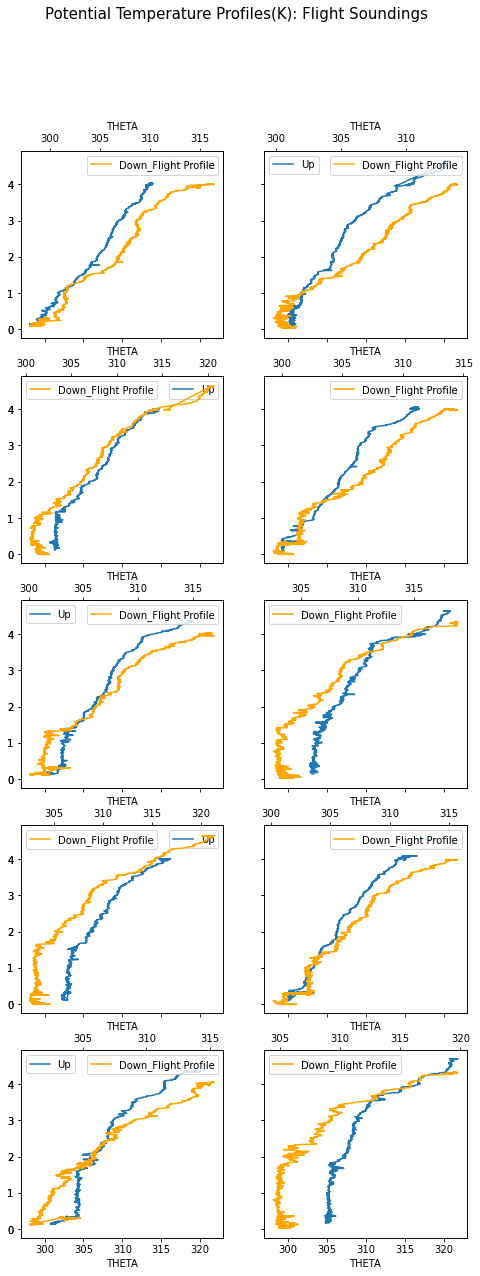

In [290]:
'''Final soundings and pbl values'''
nrow=5
ncol=2

fig, axes = plt.subplots(nrow, ncol, figsize = (8,20), sharex=True, sharey=True)
plt.suptitle('Potential Temperature Profiles(K): Flight Soundings', fontsize = 15)

count=0
for r in range(nrow):
    for c in range(ncol):
        ax1 = Up_sounding[count].plot(ax=axes[r,c],y = "GPS_ALT", x = "THETA", label="Up")
        ax2 = ax1.twiny()
        Down_sounding[count].plot(ax=ax2,y = "GPS_ALT", x = "THETA", color = 'orange', label="Down_Flight Profile")
        # plt.tick_params('x', labelbottom=False)
        count+=1
plt.legend()        
plt.show()


